In [1]:
import numpy as np
import matplotlib.pyplot as plot
import ot
import torch
from scipy.optimize import linprog

In [69]:
# CONSTANTS

MAP_DIM = 5
points = []


for x in range(MAP_DIM):
    for y in range(MAP_DIM):
        points.append([x,y])


points = np.array(points)
A_Mass = np.random.rand(1, MAP_DIM**2)[0]
A_Mass /= sum(A_Mass)
B_Mass = np.random.rand(1, MAP_DIM**2)[0]
B_Mass /= sum(B_Mass)
C = ot.dist(points, points)


In [70]:
clipped = np.clip(C, a_min = 0, a_max= 20)

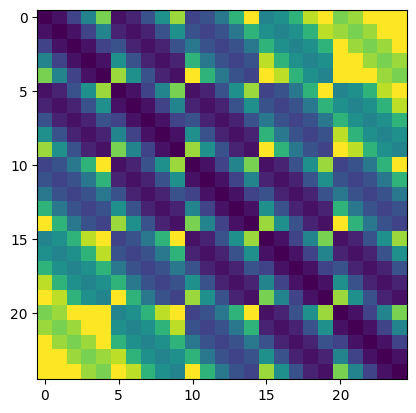

In [71]:
plot.imshow(clipped)

In [61]:
#C = ot.dist(points, points)
emd = ot.lp.emd(A_Mass, B_Mass, clipped)

In [53]:
output = demo_wasserstein(points, A_Mass, B_Mass, clipped)[1]

cost matrix constructed
running the lin prog
lin prog ran


In [52]:
def demo_wasserstein(x, p, q, C):

    # Check inputs.
    if (abs(p.sum() - 1) > 1e-9) or (abs(p.sum() - q.sum()) > 1e-9):
        raise ValueError("Expected normalized probability masses.")

    if np.any(p < 0) or np.any(q < 0):
        raise ValueError("Expected nonnegative mass vectors.")

    if (x.shape[0] != p.size) or (p.size != q.size):
        raise ValueError("Dimension mismatch.")

    # Compute pairwise costs between all xs.
    n, d = x.shape
    print("cost matrix constructed")

    Ap, Aq = [], []
    z = np.zeros((n, n))
    z[:, 0] = 1

    for i in range(n):
        Ap.append(z.ravel())
        Aq.append(z.transpose().ravel())
        z = np.roll(z, 1, axis=1)

    # We can leave off the final constraint, as it is redundant.
    # See Remark 3.1 in Peyre & Cuturi (2019).
    A = np.row_stack((Ap, Aq))[:-1]
    b = np.concatenate((p, q))[:-1]

    # Solve linear program, recover optimal vector t.
    print("running the lin prog")
    result = linprog(C.ravel(), A_eq=A, b_eq=b)
    print("lin prog ran")
    # Reshape optimal vector into (n x n) transport plan matrix T.
    T = result.x.reshape((n, n))

    # Return Wasserstein distance and transport plan.
    return np.sqrt(np.sum(T * C)), T.T

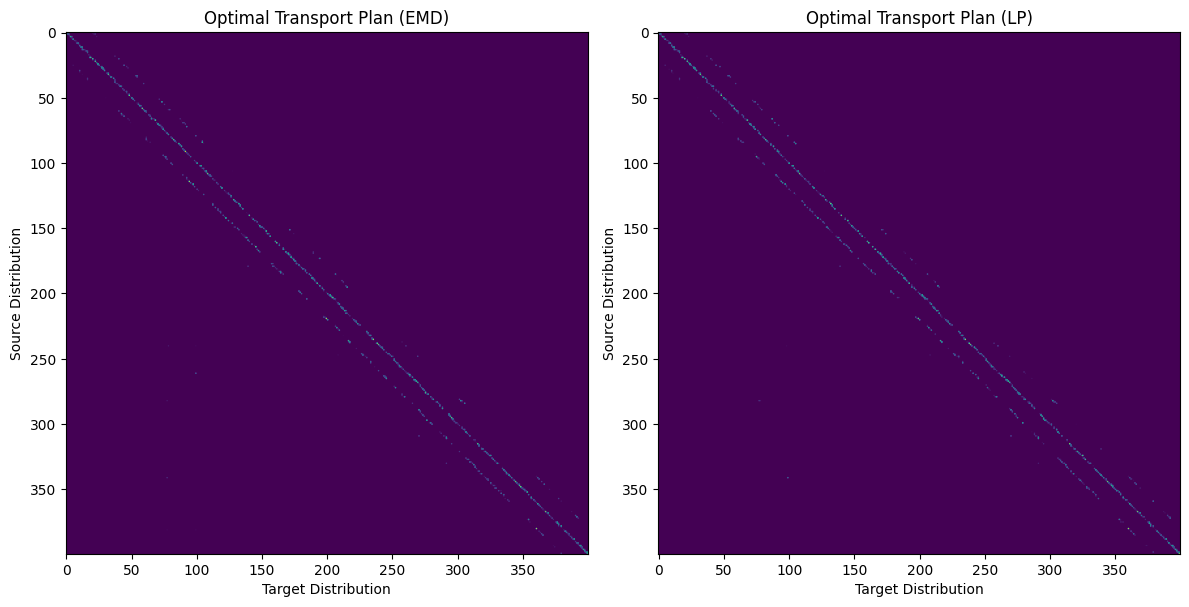

In [54]:
# Plot the results side by side
fig, axes = plot.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(emd, cmap='viridis')
axes[0].set_title("Optimal Transport Plan (EMD)")
axes[0].set_xlabel("Target Distribution")
axes[0].set_ylabel("Source Distribution")

axes[1].imshow(output, cmap='viridis')
axes[1].set_title("Optimal Transport Plan (LP)")
axes[1].set_xlabel("Target Distribution")
axes[1].set_ylabel("Source Distribution")

plot.tight_layout()
plot.show()

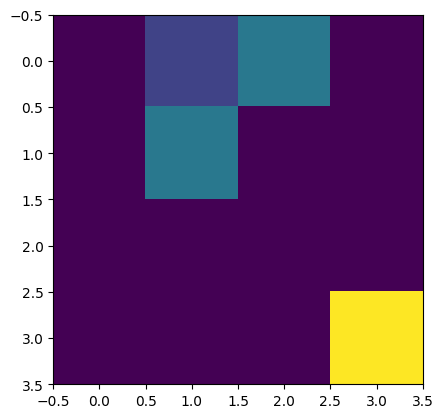

In [75]:

def emd_1d(x_a, x_b, a=None, b=None, metric='sqeuclidean', p=1., dense=True,
           log=False, check_marginals=True):

"""

    Examples
    --------

    Simple example with obvious solution. The function emd_1d accepts lists and
    performs automatic conversion to numpy arrays

    >>> import ot
    >>> a=[.5, .5]
    >>> b=[.5, .5]
    >>> x_a = [2., 0.]
    >>> x_b = [0., 3.]
    >>> ot.emd_1d(x_a, x_b, a, b)
    array([[0. , 0.5],
           [0.5, 0. ]])
    >>> ot.emd_1d(x_a, x_b)
    array([[0. , 0.5],
           [0.5, 0. ]])

    """
    
    x_a, x_b = list_to_array(x_a, x_b)
    nx = get_backend(x_a, x_b)
    if a is not None:
        a = list_to_array(a, nx=nx)
    if b is not None:
        b = list_to_array(b, nx=nx)

    assert (x_a.ndim == 1 or x_a.ndim == 2 and x_a.shape[1] == 1), \
        "emd_1d should only be used with monodimensional data"
    assert (x_b.ndim == 1 or x_b.ndim == 2 and x_b.shape[1] == 1), \
        "emd_1d should only be used with monodimensional data"

    # if empty array given then use uniform distributions
    if a is None or a.ndim == 0 or len(a) == 0:
        a = nx.ones((x_a.shape[0],), type_as=x_a) / x_a.shape[0]
    if b is None or b.ndim == 0 or len(b) == 0:
        b = nx.ones((x_b.shape[0],), type_as=x_b) / x_b.shape[0]

    # ensure that same mass
    if check_marginals:
        np.testing.assert_almost_equal(
            nx.to_numpy(nx.sum(a, axis=0)),
            nx.to_numpy(nx.sum(b, axis=0)),
            err_msg='a and b vector must have the same sum',
            decimal=6
        )
    b = b * nx.sum(a) / nx.sum(b)

    x_a_1d = nx.reshape(x_a, (-1,))
    x_b_1d = nx.reshape(x_b, (-1,))
    perm_a = nx.argsort(x_a_1d)
    perm_b = nx.argsort(x_b_1d)

    G_sorted, indices, cost = emd_1d_sorted(
        nx.to_numpy(a[perm_a]).astype(np.float64),
        nx.to_numpy(b[perm_b]).astype(np.float64),
        nx.to_numpy(x_a_1d[perm_a]).astype(np.float64),
        nx.to_numpy(x_b_1d[perm_b]).astype(np.float64),
        metric=metric, p=p
    )

    G = nx.coo_matrix(
        G_sorted,
        perm_a[indices[:, 0]],
        perm_b[indices[:, 1]],
        shape=(a.shape[0], b.shape[0]),
        type_as=x_a
    )
    if dense:
        G = nx.todense(G)
    elif str(nx) == "jax":
        warnings.warn("JAX does not support sparse matrices, converting to dense")
    if log:
        log = {'cost': nx.from_numpy(cost, type_as=x_a)}
        return G, log
    return G


In [41]:

# Number of elements in each distribution
n, m = len(A_Mass), len(B_Mass)
# Flatten the cost matrix for the linear programming formulation
cost_flat = cost_matrix.flatten()

# Constraints: The sum of the transport plans should match the supply and demand
A_eq = np.zeros((n + m, n * m))

# Supply constraints
for i in range(n):
    A_eq[i, i * m:(i + 1) * m] = 1

# Demand constraints
for j in range(m):
    A_eq[n + j, j::m] = 1

# Right-hand side of the equality constraints
b_eq = np.concatenate([a, b])

# Bounds for the transport plan variables
bounds = [(0, None)] * (n * m)

# Solve the linear programming problem
result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

# Extract the optimal transport plan
G = result.x.reshape(n, m)

In [43]:
otemd = ot.emd(A_Mass, B_Mass, cost_matrix)

/var/folders/_4/ykqt5y3x1g9g_q8_17d7jbhm0000gn/T/ipykernel_10293/1605897764.py:1: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  otemd = ot.emd(A_Mass, B_Mass, cost_matrix)


In [44]:
otemd

array([[1, 0],
       [0, 1]])

In [42]:
G

array([[0.4, 0. ],
       [0.1, 0.5]])

In [39]:
cost_matrix

array([[1, 8],
       [1, 2]])

In [21]:
import numpy as np
from scipy.optimize import linprog

# Define two discrete distributions
a = np.array([0.4, 0.6])  # Distribution a
b = np.array([0.5, 0.5])  # Distribution b

# Number of elements in each distribution
n, m = len(a), len(b)

# Define the cost matrix (Euclidean distance in 1D case)
M = np.array([[0.0, 1.0],
              [1.0, 0.0]])

# Flatten the cost matrix for the linear programming formulation
c = M.flatten()

# Constraints: The sum of the transport plans should match the supply and demand
A_eq = np.zeros((n + m, n * m))

# Supply constraints
for i in range(n):
    A_eq[i, i * m:(i + 1) * m] = 1

# Demand constraints
for j in range(m):
    A_eq[n + j, j::m] = 1

# Right-hand side of the equality constraints
b_eq = np.concatenate([a, b])

# Bounds for the transport plan variables
bounds = [(0, None)] * (n * m)

# Solve the linear programming problem
result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

# Extract the optimal transport plan
G = result.x.reshape(n, m)

print("Optimal Transport Plan:\n", G)
print("Total transportation cost:", result.fun)

Optimal Transport Plan:
 [[0.4 0. ]
 [0.1 0.5]]
Total transportation cost: 0.09999999999999998


In [22]:
cost_matrix = ot.dist(a, b)
plot.imshow(cost_matrix)
plot.xlabel("Distribution B (Red)")
plot.ylabel("Distribution A (Blue)")
plot.xlim(0,1)
plot.ylim(0,1)

ValueError: einstein sum subscripts string contains too many subscripts for operand 0

In [ ]:
    """
    Computes order-2 Wasserstein distance between two
    discrete distributions.

    Parameters
    ----------
    x : ndarray, has shape (num_bins, dimension)
    
        Locations of discrete atoms (or "spatial bins")

    p : ndarray, has shape (num_bins,)

        Probability mass of the first distribution on each atom.

    q : ndarray, has shape (num_bins,)

        Probability mass of the second distribution on each atom.

    Returns
    -------
    dist : float

        The Wasserstein distance between the two distributions.

    T : ndarray, has shape (num_bins, num_bins)

        Optimal transport plan. Satisfies p == T.sum(axis=0)
        and q == T.sum(axis=1).

    Note
    ----
    This function is meant for demo purposes only and is not
    optimized for speed. It should still work reasonably well
    for moderately sized problems.
    """

In [45]:
def demo_wasserstein(x, p, q):

    # Check inputs.
    if (abs(p.sum() - 1) > 1e-9) or (abs(p.sum() - q.sum()) > 1e-9):
        raise ValueError("Expected normalized probability masses.")

    if np.any(p < 0) or np.any(q < 0):
        raise ValueError("Expected nonnegative mass vectors.")

    if (x.shape[0] != p.size) or (p.size != q.size):
        raise ValueError("Dimension mismatch.")

    # Compute pairwise costs between all xs.
    n, d = x.shape
    C = squareform(pdist(x, metric="sqeuclidean"))

    # Scipy's linear programming solver will accept the problem in
    # the following form:
    # 
    # minimize     c @ t        over t
    # subject to   A @ t == b
    #
    # where we specify the vectors c, b and the matrix A as parameters.

    # Construct matrices Ap and Aq encoding marginal constraints.
    # We want (Ap @ t == p) and (Aq @ t == q).
    Ap, Aq = [], []
    z = np.zeros((n, n))
    z[:, 0] = 1

    for i in range(n):
        Ap.append(z.ravel())
        Aq.append(z.transpose().ravel())
        z = np.roll(z, 1, axis=1)

    # We can leave off the final constraint, as it is redundant.
    # See Remark 3.1 in Peyre & Cuturi (2019).
    A = np.row_stack((Ap, Aq))[:-1]
    b = np.concatenate((p, q))[:-1]

    # Solve linear program, recover optimal vector t.
    result = linprog(C.ravel(), A_eq=A, b_eq=b)

    # Reshape optimal vector into (n x n) transport plan matrix T.
    T = result.x.reshape((n, n))

    # Return Wasserstein distance and transport plan.
    return np.sqrt(np.sum(T * C)), T